In [1]:
import FlockModel
import importlib
import numpy as np
import matplotlib.pyplot as plt

Viscek:
Stated briefly as rules, and in $\textbf{order of decreasing precedence}$, the behaviors that lead to simulated flocking are:
1. Collision Avoidance: avoid collisions with nearby
flockmates
2. Velocity Matching: attempt to match velocity with nearby
flockmates
3. Flock Centering: attempt to stay close to nearby flockmates 

In [ ]:
phenotypes = ["4"]
angles = [np.pi, np.pi/2, np.pi/3, np.pi/4]

for angle in angles:
    for phenotype in phenotypes:
        model = Model(dt = 0.1, maxtime = 100, noise = 0.01, phenotype = phenotype, angle = angle)
        model.run(), 
        model.animate(name = str(phenotype) + str(angle))

${\displaystyle \operatorname {distance} (P_{1},P_{2},(x_{0},y_{0}))={\frac {|(x_{2}-x_{1})(y_{1}-y_{0})-(x_{1}-x_{0})(y_{2}-y_{1})|}{\sqrt {(x_{2}-x_{1})^{2}+(y_{2}-y_{1})^{2}}}}.}$

# Create CSV of positions for blender (TEST)

In [49]:
phenotypes = ["1", "2", "3", "4", "5", "6", "7", "8", "Viscek", "Random"]
for phenotype in phenotypes:

    model = Model(dt = 0.25, maxtime = 100, noise = 0.01, phenotype = phenotype)
    model.run(), 
    model.blender_csv()

# Connected correlation function test

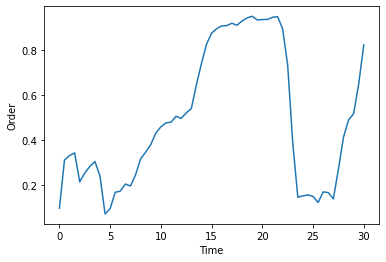

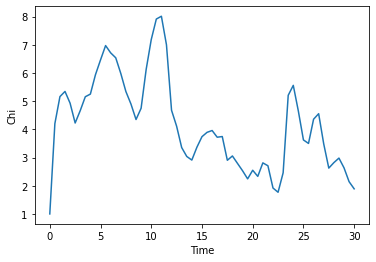

In [3]:
importlib.reload(FlockModel)

model = FlockModel.Model(dt = 0.5, maxtime = 30, noise = 0.1, phenotype = [0,1,0], density=1)
model.run()
model.animate(name="correlation_test")
model.order_plot()
model.sus_plot()

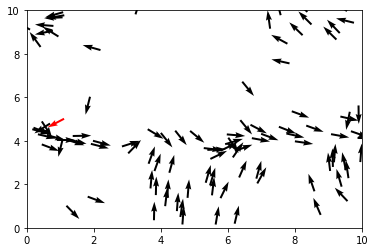

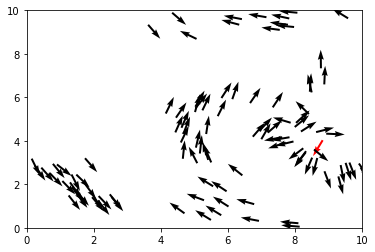

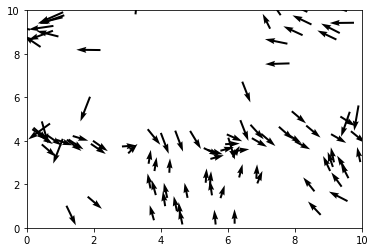

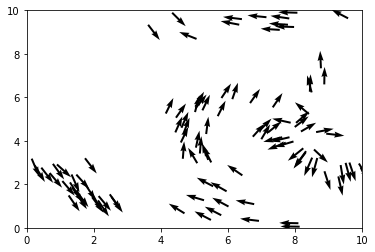

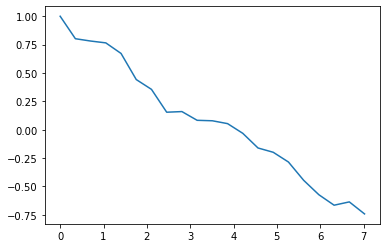

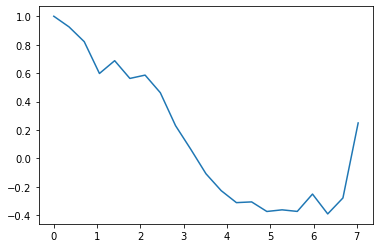

In [4]:
model.quiver_plot(i=3)
model.quiver_plot(i=9)
model.vel_fluc_plot(i=3)
model.vel_fluc_plot(i=9)
model.corr_plot(i=3)
model.corr_plot(i=9)